### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://qiskit.org/textbook/ch-applications/vqe-molecules.html

In [1]:
from qiskit import QuantumCircuit, Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.circuit.library import RealAmplitudes, EfficientSU2, ZFeatureMap, PauliFeatureMap
from qiskit_machine_learning.neural_networks import CircuitQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor
from qiskit.opflow import PauliSumOp
from qiskit.opflow.gradients import Gradient
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.neural_networks import TwoLayerQNN
from qiskit.circuit import Parameter
from IPython.display import clear_output

import time
from math import asin, sqrt, ceil
from qiskit.opflow import Z, CircuitStateFn, StateFn, PauliExpectation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

algorithm_globals.random_seed = 42

In [2]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [3]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [4]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

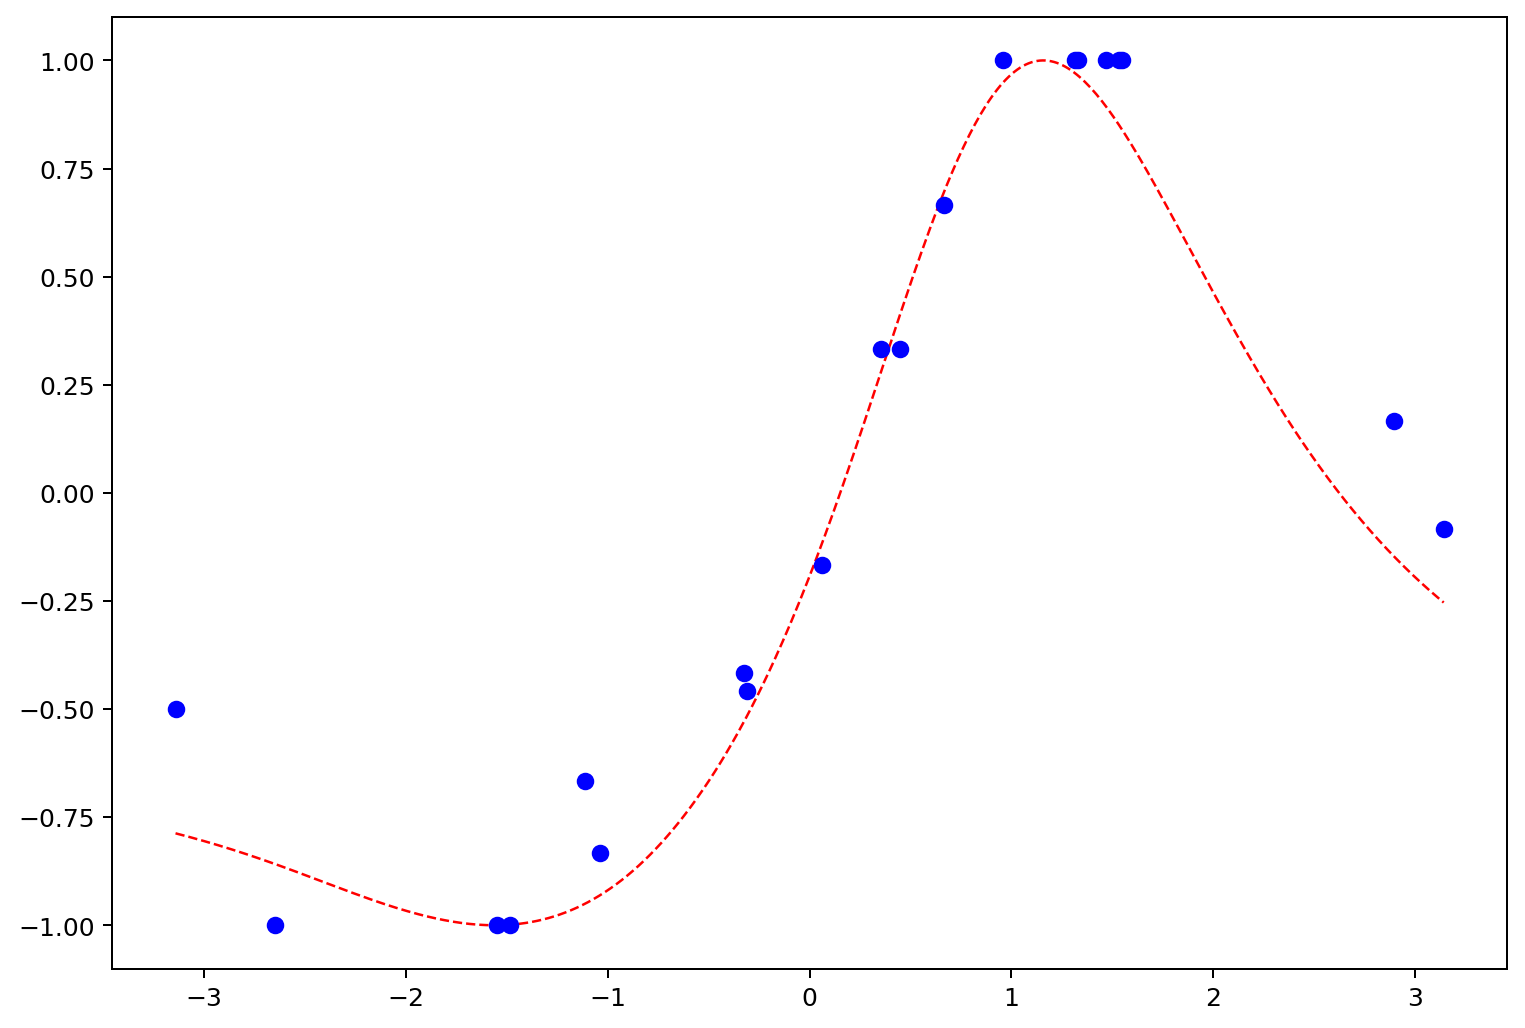

In [5]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

XX = X_[indices].reshape(-1,1)
yy = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

yy = detrend(yy)

#XX = scale(XX, 0, 1)
XX = scale(XX) # from -pi to pi
yy = scale(yy, -1, 1)

#X_ = scale(X_, 0, 1)
X_ = scale(X_) # from -pi to pi
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(XX, yy, "bo", label = 'Points to fit')
plt.show()

## Quantum Neural Network

In [6]:
num_qubits = XX.shape[1]

In [7]:
backend = Aer.get_backend('statevector_simulator')

In [8]:
# specify the observable
observable = PauliSumOp.from_list([("ZZ" * num_qubits, 1)])
print(observable)

1.0 * ZZ


In [9]:
quantum_instance = QuantumInstance(backend, 
                                   shots = 1024, 
                                   seed_simulator = algorithm_globals.random_seed, 
                                   seed_transpiler = algorithm_globals.random_seed)

In [10]:
# construct simple feature map
param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

# construct simple ansatz
param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

observable = PauliSumOp.from_list([("Z" * 1, 0.8)])

# construct QNN
regression_opflow_qnn = TwoLayerQNN(1, feature_map, ansatz, observable = observable, quantum_instance=quantum_instance)

In [11]:
# define (random) input and weights
input3 = algorithm_globals.random.random(regression_opflow_qnn.num_inputs)
weights3 = algorithm_globals.random.random(regression_opflow_qnn.num_weights)

In [12]:
# QNN forward pass
regression_opflow_qnn.forward(input3, weights3)

# QNN forward pass
regression_opflow_qnn.forward(input3, weights3)

array([[0.2802928]])

In [13]:
#optimizer = COBYLA(maxiter = 400, tol = 0.001)
optimizer = L_BFGS_B()

In [14]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait = True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [15]:
qnnr = NeuralNetworkRegressor(
    neural_network=regression_opflow_qnn,
    loss = "squared_error",
    optimizer = optimizer,
    callback = callback_graph,
)

In [16]:
start = time.time()

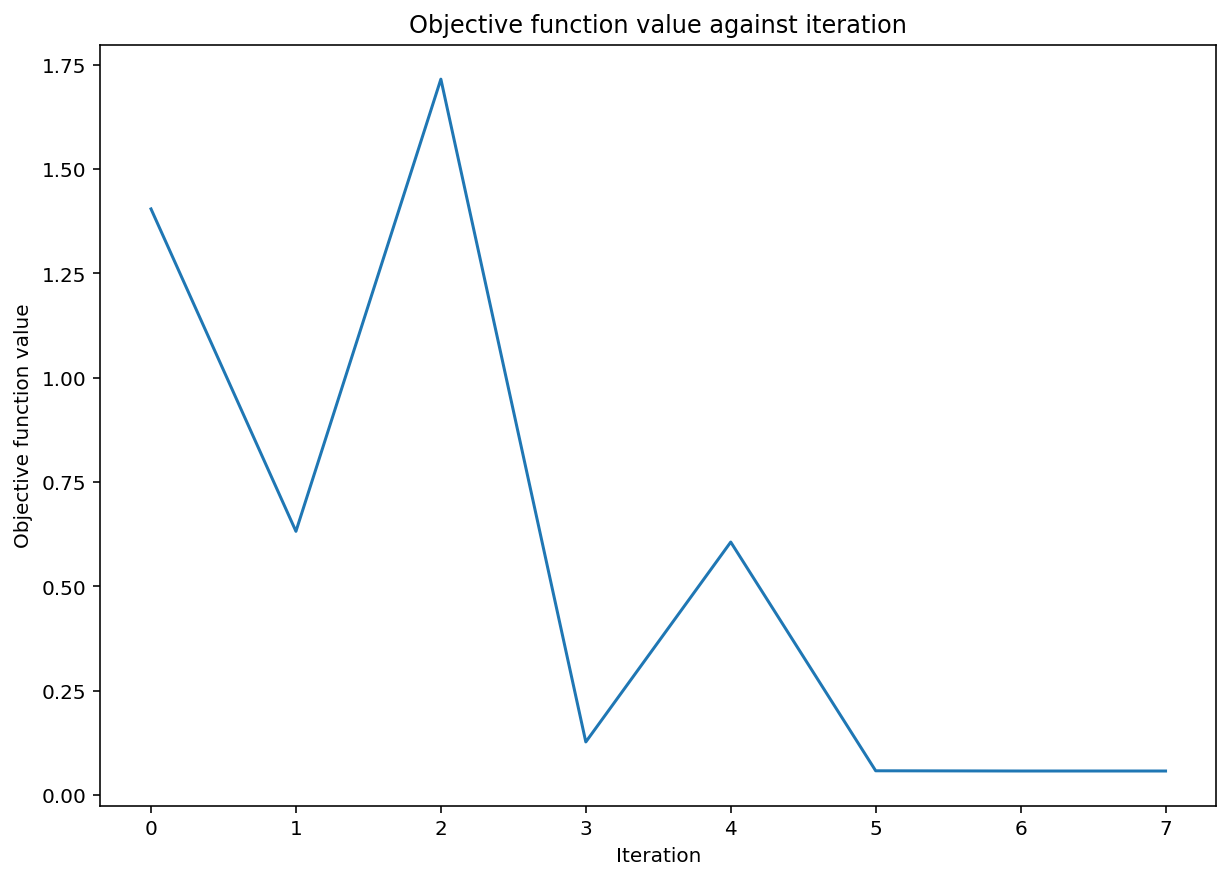

Time elapsed:  1.615544080734253


In [17]:
plt.rcParams['figure.figsize'] = [10, 7]

objective_func_vals = []

y_train_fit = yy.reshape(-1,)

qnnr.fit(XX, yy.reshape(-1,))

elapsed = time.time() - start

print("Time elapsed: ", elapsed)

plt.show()

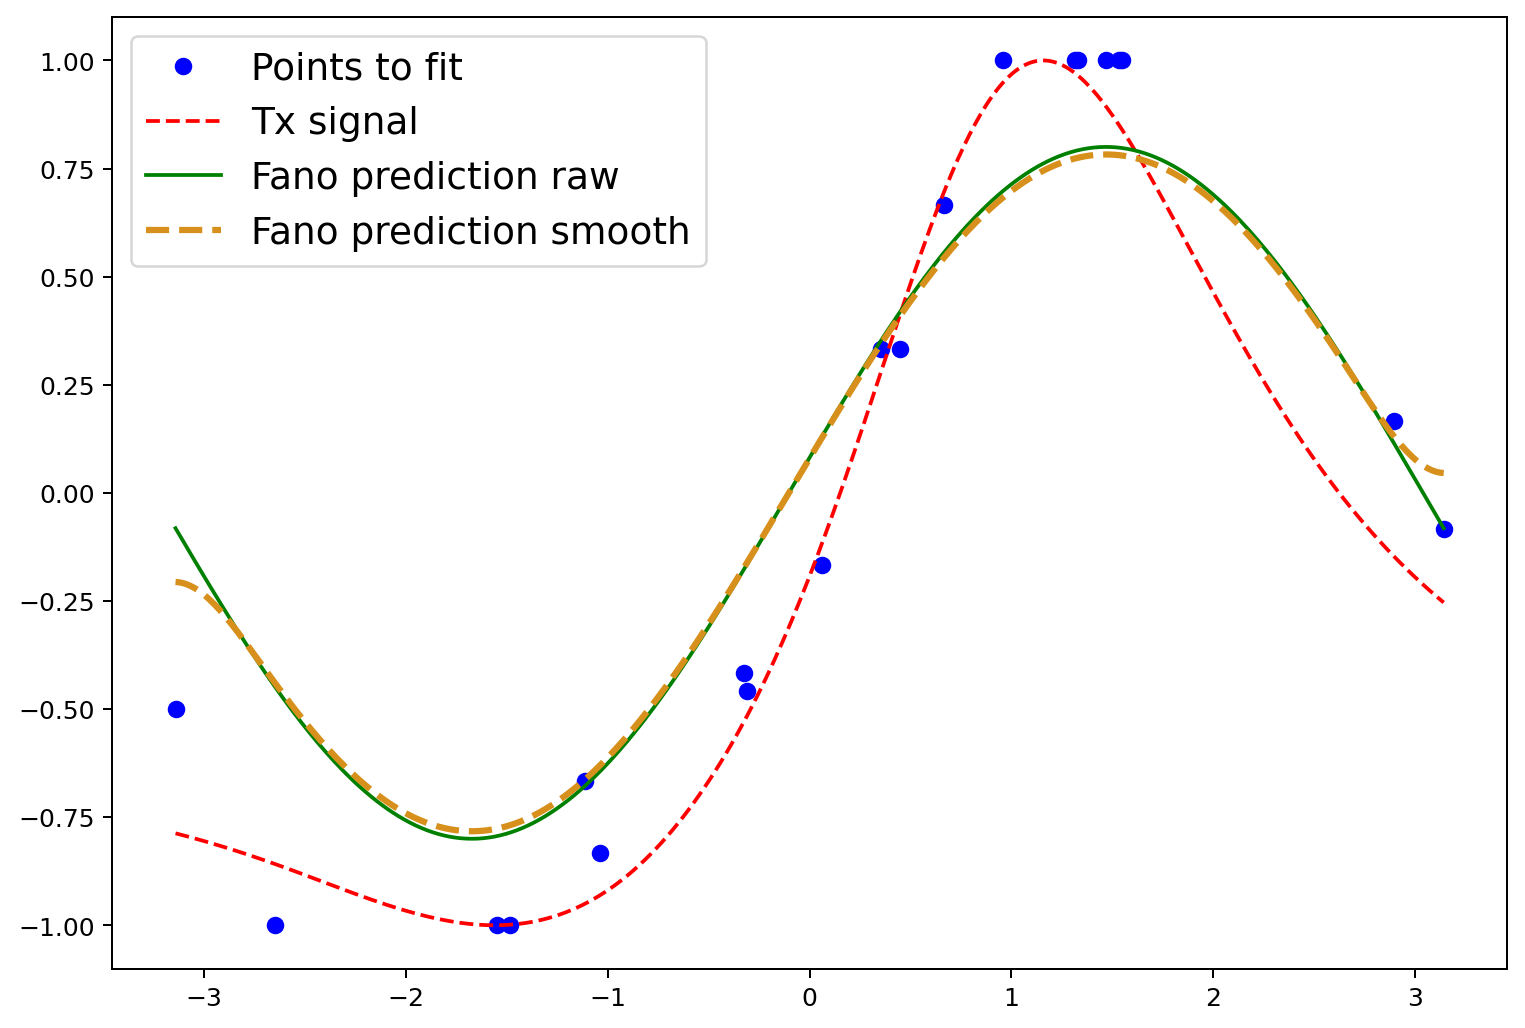

In [18]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(XX, yy.reshape(-1,), "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot fitted line
y_predict = qnnr.predict(X_)
y_predict_smooth = smooth(y_predict)
plt.plot(X_, y_predict, "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth, "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')

plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [19]:
qnnr.score(X_, y_)

0.8303948313189593

In [20]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright